Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

In [1]:
NAME = "Weijie Yuan"
COLLABORATORS = ""

---

# Project 2: NYC Taxi Rides
# Extras

Put all of your extra work in here. Feel free to save figures to use when completing Part 4.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from pathlib import Path
from sqlalchemy import create_engine

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

%matplotlib inline

# Data selection

January 2016 was an odd month for taxi rides due to the blizzard. It helps us to select train data and validation data from the other five months. Then we use the same method as those in part 1 to deal with the data. After that, we get a new hdf file called 'cleaned_new.hdf'.

In [3]:
!ls -lh /srv/db/taxi_2016_student_small.sqlite

ls: /srv/db/taxi_2016_student_small.sqlite: No such file or directory


In [6]:
DB_URI = "sqlite:////srv/db/taxi_2016_student_small.sqlite"
TABLE_NAME = "taxi"

sql_engine = create_engine(DB_URI)

In [ ]:
data_query = f"""
            SELECT * 
            FROM {TABLE_NAME}
            WHERE tpep_pickup_datetime
                BETWEEN '2016-02-01' AND '2016-07-01'
                AND record_id % 100 == 0
            ORDER BY tpep_pickup_datetime
            """

# Clean long duration
cleaned1_query = f"""
            SELECT *
            FROM ({data_query})
            WHERE julianday(tpep_dropoff_datetime)-julianday(tpep_pickup_datetime) < 0.5
            """

# Clean location out of Mahattan
def bounding_condition(lat_l, lat_u, lon_l, lon_u):
    return f"""
            pickup_longitude <= {lon_u} AND
            pickup_longitude >= {lon_l} AND
            dropoff_longitude <= {lon_u} AND
            dropoff_longitude >= {lon_l} AND
            pickup_latitude <= {lat_u} AND
            pickup_latitude >= {lat_l} AND
            dropoff_latitude <= {lat_u} AND
            dropoff_latitude >= {lat_l} 
            """
lat_l = 40.63
lat_u = 40.85
lon_l = -74.03
lon_u = -73.75

cleaned2_query = f"""
            SELECT *
            FROM ({cleaned1_query})
            WHERE {bounding_condition(lat_l, lat_u, lon_l, lon_u)}
            """

# Clean record of which passenger_count = 0 
cleaned3_query = f"""
            SELECT *
            FROM ({cleaned2_query})
            WHERE passenger_count>0
            """

cleaned_new = pd.read_sql_query(cleaned3_query, sql_engine)
cleaned_new.shape

cleaned_new['tpep_pickup_datetime'] = pd.to_datetime(cleaned_new['tpep_pickup_datetime'])
cleaned_new['tpep_dropoff_datetime'] = pd.to_datetime(cleaned_new['tpep_dropoff_datetime'])

cleaned_new['duration'] = cleaned_new["tpep_dropoff_datetime"]-cleaned_new["tpep_pickup_datetime"]
cleaned_new['duration'] = cleaned_new['duration'].dt.total_seconds()

# Split train dataset and val dataset
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(cleaned_new, test_size=0.2, random_state=42)

Path("data").mkdir(parents=True, exist_ok=True)
data_file = Path("data", "cleaned_new.hdf") # Path of hdf file
train_df.to_hdf(data_file, "train") # Train data of hdf file
val_df.to_hdf(data_file, "val") # Val data of hdf file

In [3]:
# Run this cell to load the data. 
data_file = Path("data", "cleaned_new.hdf")
train_df = pd.read_hdf(data_file, "train")
val_df = pd.read_hdf(data_file, "val")

# Data cleaning

Firstly, we should handle missing values in test data. As we do with our train data and validation data, we replace the missing values in test data with mean.

In [4]:
# replace missing values with mean
def replace_miss_by_mean(df):
    """
    Replace missing value in pickup/dropoff_long and pickup/dropoff_lat by its mean
    """
    df.loc[df['pickup_latitude'] == 0, 'pickup_latitude'] = \
    np.mean(df.loc[df['pickup_latitude'] != 0, 'pickup_latitude'])
    df.loc[df['pickup_longitude'] == 0, 'pickup_longitude'] = \
    np.mean(df.loc[df['pickup_longitude'] != 0, 'pickup_longitude'])
    df.loc[df['dropoff_latitude'] == 0, 'dropoff_latitude'] = \
    np.mean(df.loc[df['dropoff_latitude'] != 0, 'dropoff_latitude'])
    df.loc[df['dropoff_longitude'] == 0, 'dropoff_longitude'] = \
    np.mean(df.loc[df['dropoff_longitude'] != 0, 'dropoff_longitude'])
    
    return df

In [5]:
test_df = pd.read_csv("./proj2_test_data.csv")
test_df['tpep_pickup_datetime'] = pd.to_datetime(test_df['tpep_pickup_datetime'])
test_df.head()

,record_id,VendorID,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,10000,1,2016-01-02 01:45:37,1,1.20,-73.982224,40.768620,1,N,-73.983765,40.779598,1,6.0,0.5,0.5,2.00,0.0,0.3,9.30
1,19000,2,2016-01-02 03:05:16,1,10.90,-73.999977,40.738121,1,N,-73.888657,40.824364,1,31.5,0.5,0.5,6.56,0.0,0.3,39.36
2,21000,1,2016-01-02 03:24:36,1,1.80,-73.986618,40.747379,1,N,-73.978508,40.729622,1,8.5,0.5,0.5,1.96,0.0,0.3,11.76
3,23000,2,2016-01-02 03:47:38,1,5.95,-74.002922,40.744572,1,N,-73.942413,40.786419,1,20.5,0.5,0.5,4.36,0.0,0.3,26.16
4,27000,1,2016-01-02 04:36:44,1,1.60,-73.986366,40.759464,1,N,-73.963081,40.760353,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30


In [6]:
test_df = replace_miss_by_mean(test_df)

Then we should consider the outliers of duration.

/Users/dogspro/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


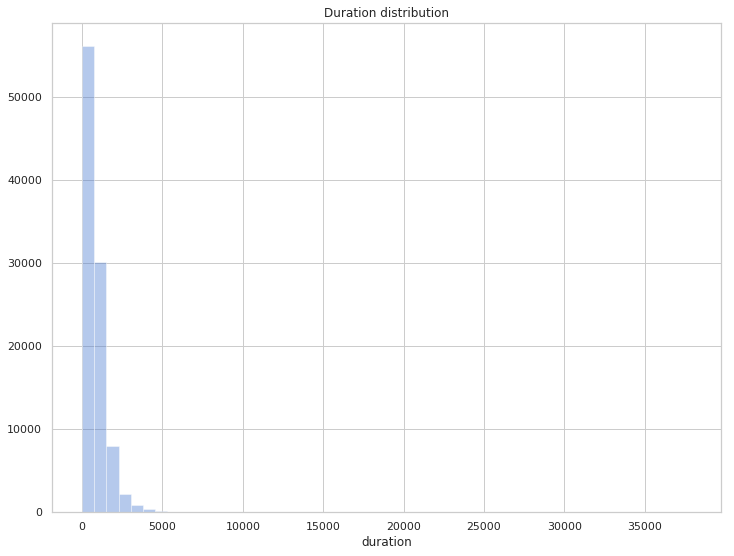

In [7]:
fig, ax = plt.subplots(figsize=(12, 9))

# Plot the distribution of duration using sns.distplot
# You can fill `ax=ax` to sns.distplot to plot in the ax object created above

sns.distplot(train_df['duration'], ax=ax, kde=False)

plt.title('Duration distribution');

In [8]:
# Set outliers of duration as a constant upper limit
train_df.loc[train_df['duration']>7000,'duration'] = 7000

# Feature selection

In [9]:
# refer the external dataset 'collisions'
dest_path = 'data/collisions.zip'
collisions_zip = zipfile.ZipFile(dest_path, 'r')

#Extract zip files 
collisions_dir = Path('data/collisions')
collisions_zip.extractall(collisions_dir)

In [10]:
# Run this cell to load the collisions data. 
skiprows = None
collisions = pd.read_csv(collisions_dir/'collisions_2016.csv', index_col='UNIQUE KEY', 
                         parse_dates={'DATETIME':["DATE","TIME"]}, skiprows=skiprows)
collisions['TIME'] = pd.to_datetime(collisions['DATETIME']).dt.hour
collisions['DATE'] = pd.to_datetime(collisions['DATETIME']).dt.date
collisions = collisions.dropna(subset=['LATITUDE', 'LONGITUDE'])
collisions = collisions[collisions['LATITUDE'] <= 40.85]
collisions = collisions[collisions['LATITUDE'] >= 40.63]
collisions = collisions[collisions['LONGITUDE'] <= -73.65]
collisions = collisions[collisions['LONGITUDE'] >= -74.03]

In [11]:
collisions['SEVERITY'] = collisions.filter(regex=r'NUMBER OF *').sum(axis=1)
collisions['FATALITY'] = collisions.filter(regex=r'KILLED').sum(axis=1)
collisions['INJURY'] = collisions.filter(regex=r'INJURED').sum(axis=1)
collisions['START'] = collisions['DATETIME']
collisions['END'] = collisions['START'] + pd.Timedelta(hours=1)
collisions_subset = collisions[['DATETIME', 'TIME', 'START', 'END', 
                                'DATE', 'LATITUDE', 'LONGITUDE', 'SEVERITY']]
# YOUR CODE HERE
collisions_subset.head(5)

,DATETIME,TIME,START,END,DATE,LATITUDE,LONGITUDE,SEVERITY
UNIQUE KEY,,,,,,,,
3589202,2016-12-29 00:00:00,0,2016-12-29 00:00:00,2016-12-29 01:00:00,2016-12-29,40.844107,-73.897997,0
3587413,2016-12-26 14:30:00,14,2016-12-26 14:30:00,2016-12-26 15:30:00,2016-12-26,40.692347,-73.881778,0
3578151,2016-11-30 22:50:00,22,2016-11-30 22:50:00,2016-11-30 23:50:00,2016-11-30,40.755480,-73.741730,2
3567096,2016-11-23 20:11:00,20,2016-11-23 20:11:00,2016-11-23 21:11:00,2016-11-23,40.771122,-73.869635,0
3565211,2016-11-21 14:11:00,14,2016-11-21 14:11:00,2016-11-21 15:11:00,2016-11-21,40.828918,-73.838403,0


In [12]:
# Copied from part 2
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

# Copied from part 2
def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

# Copied from part 2
def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# Copied from part 2
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
    return df

# Copied from part 2
def add_distance_columns(df):
    """
    Add distance features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    return df

def select_columns(data, *columns):
    return data.loc[:, columns]

In [13]:
# Add features relative to accidents
def add_accident_columns(df):
    df_reset = df.copy()
    df_reset = df_reset.reset_index() 
    df_reset = df_reset[['index', 'tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude']]
    df_reset['date'] = df_reset['tpep_pickup_datetime'].dt.date
    
    merged = df_reset.merge(collisions_subset, left_on = "date", right_on = "DATE", how = "left")
    
    start_to_accident = haversine(merged['pickup_latitude'].values,
                                  merged['pickup_longitude'].values,
                                  merged['LATITUDE'].values,
                                  merged['LONGITUDE'].values)
    merged['start_to_accident'] = start_to_accident
    # count accident conditioned on time

    # condition on time
    index_temporal = (((merged['tpep_pickup_datetime'] >= merged['START']) & \
                       (merged['tpep_pickup_datetime'] <= merged['END'])))

    # count accidents
    merged['accident_close'] = 0
    merged.loc[index_temporal, 'accident_close'] = 1
    temporal_accidents = merged.groupby(['index'])['accident_close'].sum().to_frame()
    

    # conditioned on space
    # Spatial locality

    # Condition on space
    index_spatial = (merged['start_to_accident'] <= 5)

    # Count accidents
    merged['accident_close'] = 0
    merged.loc[index_spatial, 'accident_close'] = 1
    spatial_accidents = merged.groupby(['index'])['accident_close'].sum().to_frame()
    
    df['temporal_accidents'] = temporal_accidents
    df['spatial_accidents'] = spatial_accidents
    
    return df

In [14]:
def process_data(data, test=False):
    X = (
        data
        
        # Transform data
        .pipe(add_time_columns)
        .pipe(add_distance_columns)
        .pipe(add_accident_columns)
    )
    if test:
        y = None
    else:
        y = data['duration']
        
    return X, y

In [15]:
# Train
X_train, y_train = process_data(train_df)
X_val, y_val = process_data(val_df)

/Users/dogspro/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/dogspro/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


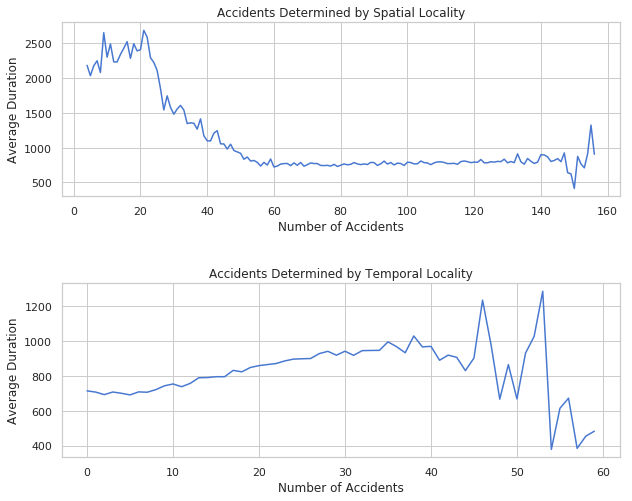

In [16]:
plt.figure(figsize=(10,8))
ax1 = plt.subplot(2, 1, 1)
ax1 = train_df.groupby('spatial_accidents')['duration'].mean().plot()
plt.title("Accidents Determined by Spatial Locality")
plt.xlabel("Number of Accidents")
plt.ylabel("Average Duration")

ax2 = plt.subplot(2, 1, 2)
ax2 = train_df.groupby('temporal_accidents')['duration'].mean().plot()
plt.title("Accidents Determined by Temporal Locality")
plt.xlabel("Number of Accidents")
plt.ylabel("Average Duration")
plt.subplots_adjust(hspace=0.5)

plt.savefig('accidents')
plt.show();

In [17]:
train_df.columns.values

array(['record_id', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'duration', 'month', 'week_of_year', 'day_of_month', 'day_of_week',
       'hour', 'week_hour', 'manhattan', 'bearing', 'haversine',
       'temporal_accidents', 'spatial_accidents'], dtype=object)

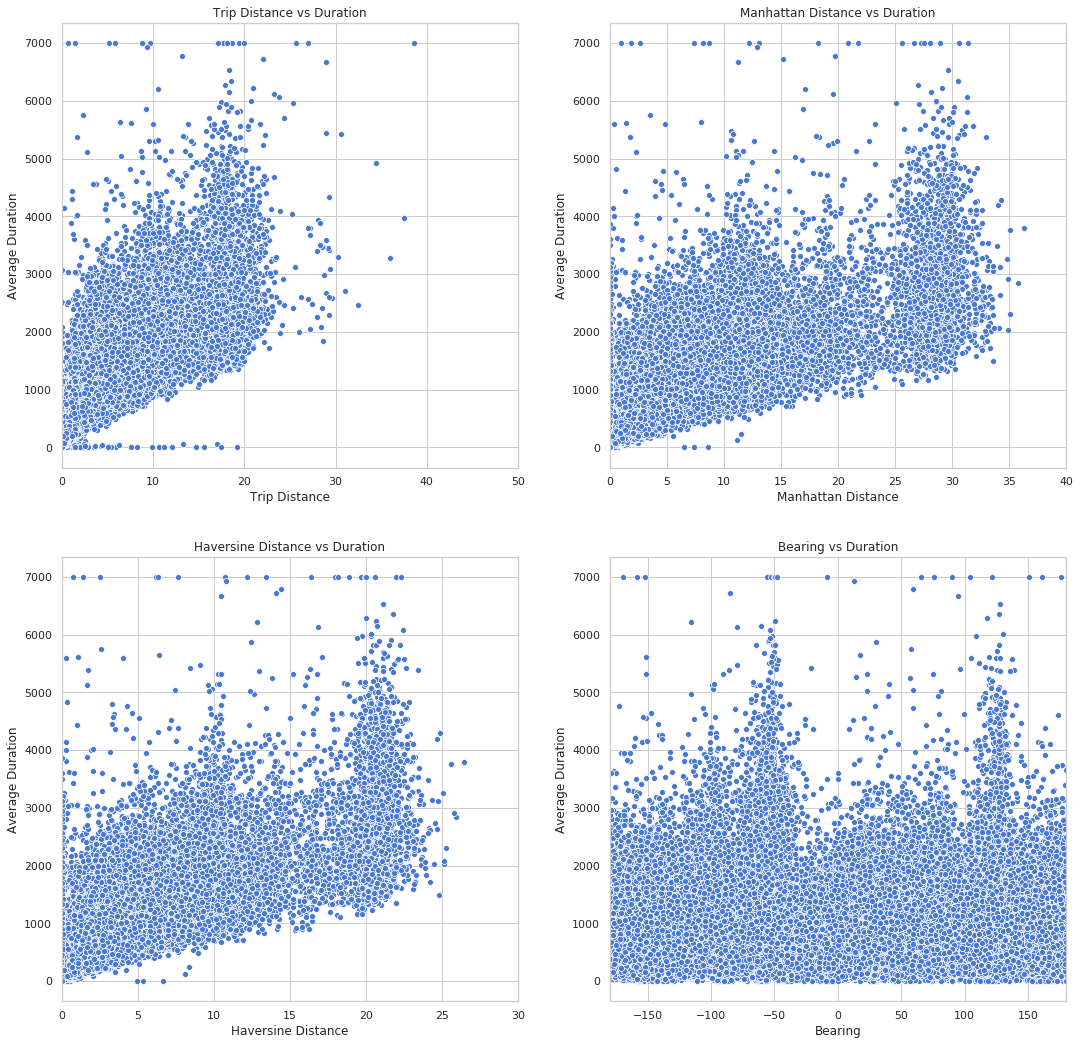

In [18]:
plt.figure(figsize=(18,18))
ax1 = plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x="trip_distance", y="duration", data=train_df)
plt.title("Trip Distance vs Duration")
plt.xlabel("Trip Distance")
plt.ylabel("Average Duration")
plt.xlim(0,50)

ax2 = plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x="manhattan", y="duration", data=train_df)
plt.title("Manhattan Distance vs Duration")
plt.xlabel("Manhattan Distance")
plt.ylabel("Average Duration")
plt.xlim(0,40)

ax3 = plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x="haversine", y="duration", data=train_df)
plt.title("Haversine Distance vs Duration")
plt.xlabel("Haversine Distance")
plt.ylabel("Average Duration")
plt.xlim(0,30)

ax4 = plt.subplot(2, 2, 4)
ax4 = sns.scatterplot(x="bearing", y="duration", data=train_df)
plt.title("Bearing vs Duration")
plt.xlabel("Bearing")
plt.ylabel("Average Duration")
plt.xlim(-180,180)

plt.savefig('distance')
plt.show();

Getting insight about distance measurement vs duration, we may conclude that bearing is not a good feature because scatter plot seems randomly distributed. And the trend in trip distance, manhattan distance and haversine distance seems similar in the above plots. So, we can just pick one of them to be our feature in the final model, like manhattan distance.

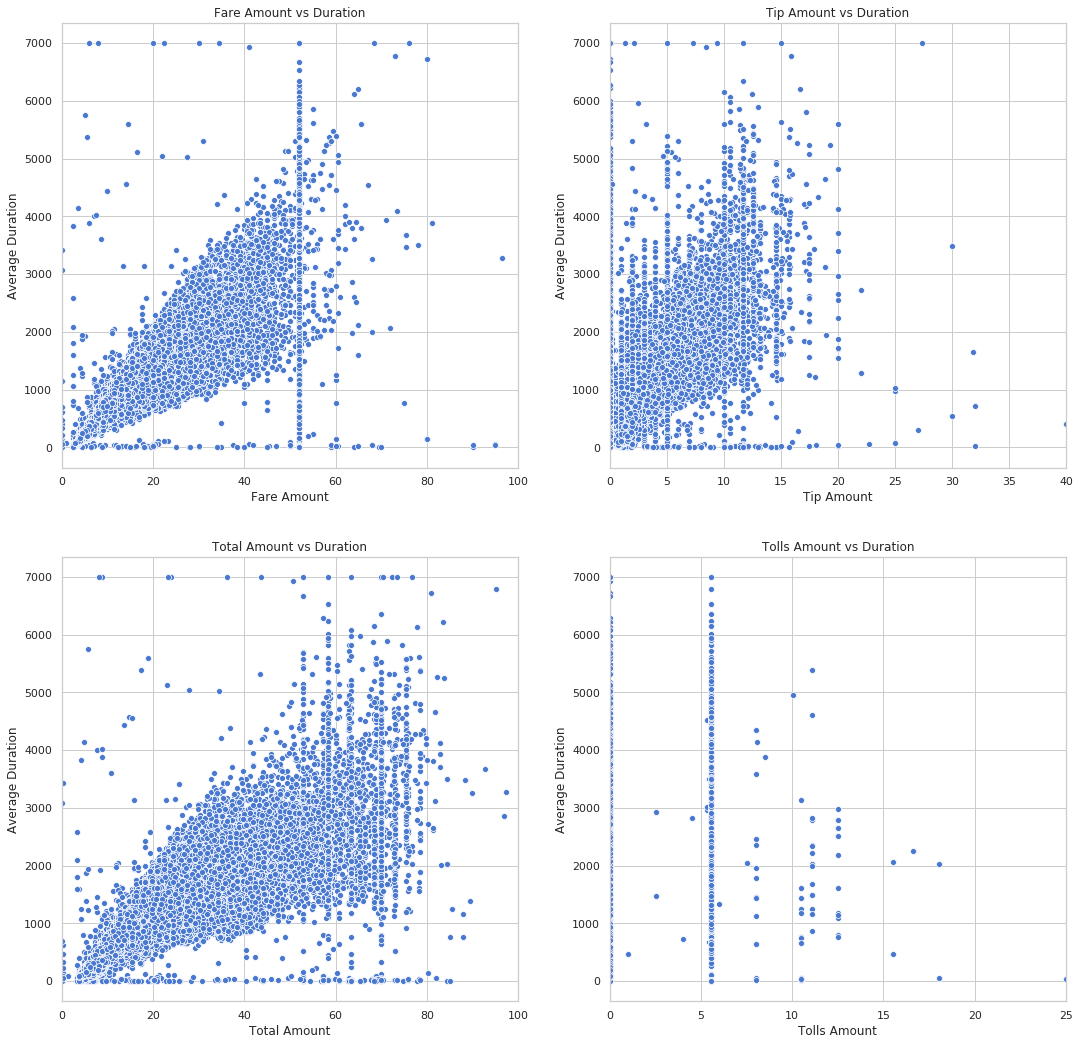

In [19]:
plt.figure(figsize=(18,18))
ax1 = plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x="fare_amount", y="duration", data=train_df)
plt.title("Fare Amount vs Duration")
plt.xlabel("Fare Amount")
plt.ylabel("Average Duration")
plt.xlim(0,100)

ax2 = plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x="tip_amount", y="duration", data=train_df)
plt.title("Tip Amount vs Duration")
plt.xlabel("Tip Amount")
plt.ylabel("Average Duration")
plt.xlim(0,40)

ax3 = plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x="total_amount", y="duration", data=train_df)
plt.title("Total Amount vs Duration")
plt.xlabel("Total Amount")
plt.ylabel("Average Duration")
plt.xlim(0,100)

ax4 = plt.subplot(2, 2, 4)
ax4 = sns.scatterplot(x="tolls_amount", y="duration", data=train_df)
plt.title("Tolls Amount vs Duration")
plt.xlabel("Tolls Amount")
plt.ylabel("Average Duration")
plt.xlim(0,25)

plt.savefig('fare')
plt.show();

It seems that fare amount, tip amount and total amount are all positively related to the duration of ride. So we may try out these three features into our model.

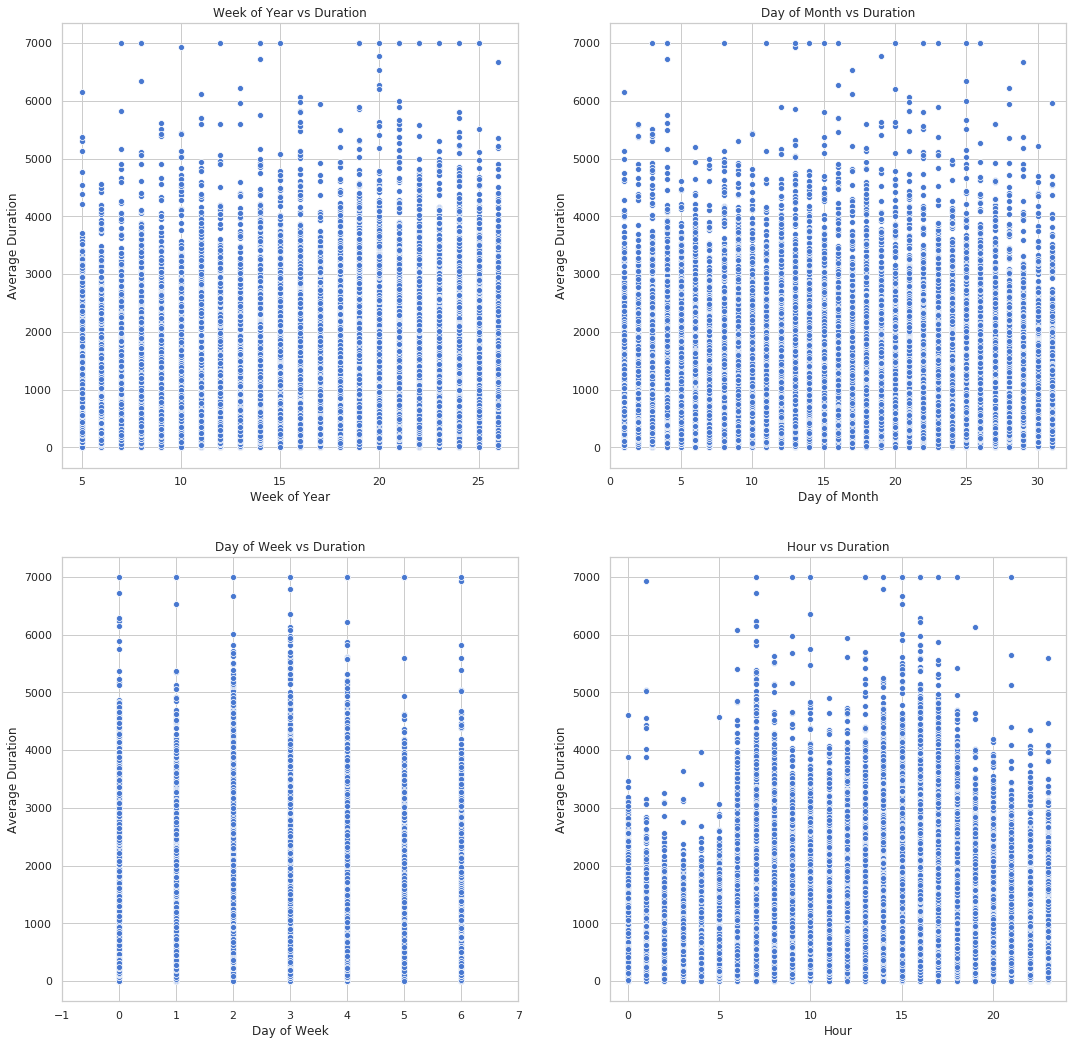

In [20]:
plt.figure(figsize=(18,18))
ax1 = plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(x="week_of_year", y="duration", data=train_df)
plt.title("Week of Year vs Duration")
plt.xlabel("Week of Year")
plt.ylabel("Average Duration")
plt.xlim(4,27)

ax2 = plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(x="day_of_month", y="duration", data=train_df)
plt.title("Day of Month vs Duration")
plt.xlabel("Day of Month")
plt.ylabel("Average Duration")
plt.xlim(0,32)

ax3 = plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(x="day_of_week", y="duration", data=train_df)
plt.title("Day of Week vs Duration")
plt.xlabel("Day of Week")
plt.ylabel("Average Duration")
plt.xlim(-1,7)

ax4 = plt.subplot(2, 2, 4)
ax4 = sns.scatterplot(x="hour", y="duration", data=train_df)
plt.title("Hour vs Duration")
plt.xlabel("Hour")
plt.ylabel("Average Duration")
plt.xlim(-1,24)

plt.savefig('time')
plt.show();

It seems that daily trend and weekly trend are more obviously related to the duration of taxi rides.

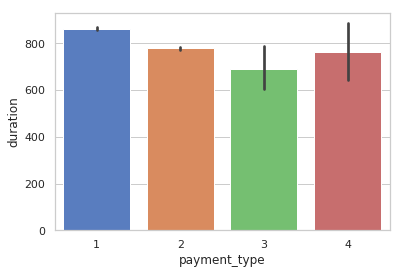

In [21]:
sns.barplot(x = 'payment_type', y = 'duration', data = train_df)
plt.savefig('payment_type')
plt.show();

# Final Model

In [22]:
# Run this cell to load the data. 
data_file = Path("data", "cleaned_new.hdf")
train_df = pd.read_hdf(data_file, "train")
val_df = pd.read_hdf(data_file, "val")

# Set outliers of duration as a constant upper limit
#train_df.loc[train_df['duration']>7000,'duration'] = 7000

In [23]:
def process_data_fm(data, test=False):
    X = (
        data
        
        # Transform data
        .pipe(add_time_columns)
        .pipe(add_distance_columns)
        .pipe(add_accident_columns)
        
        .pipe(select_columns,        
              'pickup_longitude',  
              'pickup_latitude',   
              'dropoff_longitude', 
              'dropoff_latitude',
              'manhattan',
              'hour',
              'day_of_week',
              'fare_amount',
              'tip_amount',
              'total_amount',
              'temporal_accidents',
              'spatial_accidents'
             )
    )
    if test:
        y = None
    else:
        y = data['duration']
        
    return X, y

In [42]:
# Train
X_train, y_train = process_data_fm(train_df)
X_val, y_val = process_data_fm(val_df)

/Users/dogspro/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/dogspro/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [51]:
# Save training data and validation data
Path("data").mkdir(parents=True, exist_ok=True)
data_train_file = Path("data", "train.hdf") # Path of hdf file
data_val_file = Path("data", "val.hdf")

X_train.to_hdf(data_train_file,"X_train")
y_train.to_hdf(data_train_file,"y_train")
train_df.to_hdf(data_train_file,"train_df")

X_val.to_hdf(data_val_file,"X_val")
y_val.to_hdf(data_val_file,"y_val")
val_df.to_hdf(data_val_file,"val_df")

In [52]:
import sklearn.linear_model as lm
final_model = lm.LinearRegression(fit_intercept=True)
final_model.fit(X_train, y_train)

# Predict
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)

In [53]:
def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

In [54]:
print("Validation Error: ", mae(y_val_pred, y_val))
print("Training Error: ", mae(y_train_pred, y_train))

Validation Error:  165.94362437231544
Training Error:  161.83963811939554


# Regularization

In [55]:
from sklearn.linear_model import Ridge
rfm = Ridge(alpha=1.0)
rfm.fit(X_train, y_train) 
y_train_pred_ridge = rfm.predict(X_train)
y_val_pred_ridge = rfm.predict(X_val)

print("Validation Error: ", mae(y_val_pred_ridge, y_val))
print("Training Error: ", mae(y_train_pred_ridge, y_train))

Validation Error:  165.93226343586133
Training Error:  161.82270274995457


In [56]:
from sklearn.linear_model import Lasso
lfm = Lasso(alpha=0.1)
lfm.fit(X_train, y_train) 
y_train_pred_lasso = lfm.predict(X_train)
y_val_pred_lasso = lfm.predict(X_val)

print("Validation Error: ", mae(y_val_pred_lasso, y_val))
print("Training Error: ", mae(y_train_pred_lasso, y_train))

Validation Error:  165.91937301722749
Training Error:  161.80868473380275


/Users/dogspro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


It seems that LinearRegression with regularization techniques like ridge and lasso can not obviously improve the performance of linear model on validation dataset.

# Model Selection

In [57]:
from sklearn.model_selection import GridSearchCV
gcvm = lm.LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(gcvm, parameters, cv=5)
grid.fit(X_train, y_train)

y_train_pred_grid = grid.predict(X_train)
y_val_pred_grid = grid.predict(X_val)

print("Validation Error: ", mae(y_val_pred_grid, y_val))
print("Training Error: ", mae(y_train_pred_grid, y_train))

Validation Error:  165.94362437231464
Training Error:  161.83963811939253


# Submission

In [58]:
from datetime import datetime
def generate_submission(test, predictions, force=False):
    if force:
        if not os.path.isdir("submissions"):
            os.mkdir("submissions")
        submission_df = pd.DataFrame({
            "id": test_df.index.values, 
            "duration": predictions,
        },
            columns=['id', 'duration'])

        timestamp = datetime.isoformat(datetime.now()).split(".")[0]

        submission_df.to_csv(f'submissions/submission_{timestamp}.csv', index=False)

        print(f'Created a CSV file: submission_{timestamp}.csv')
        print('You may now upload this CSV file to Kaggle for scoring.')

In [59]:
X_test, _ = process_data_fm(test_df, True)

/Users/dogspro/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/dogspro/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [63]:
Path("data").mkdir(parents=True, exist_ok=True)
data_test_file = Path("data", "test.hdf") # Path of hdf file

X_test.to_hdf(data_test_file,"X_test")
test_df.to_hdf(data_test_file, "test_df")

In [64]:
assert list(X_train.columns) == list(X_test.columns), "Different columns or different column ordering"
submission_predictions = (final_model
                          .fit(X_train, y_train)
                          .predict(X_test))
submission_predictions = submission_predictions.astype(int)
submission_predictions[submission_predictions < 0] = 0
generate_submission(test_df, submission_predictions, True)

Created a CSV file: submission_2018-12-03T21:42:23.csv
You may now upload this CSV file to Kaggle for scoring.


In [65]:
import pickle
# save the model to disk
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**